In [1]:
import tensorflow as tf
import numpy as np
import scipy

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import glob, os, sys
import pickle

In [3]:
from prior_attention import build_prior_attentions

In [4]:
from keras import backend as K
from keras.preprocessing import image
import skimage
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras import optimizers

from sklearn.model_selection import train_test_split

from keras.applications.resnet50 import ResNet50 as resnet
from keras.applications.resnet50 import preprocess_input as resnet_pp

from keras.optimizers import Adam

class Utils:
    @staticmethod
    def save_object(obj, filename):
        with open(filename, 'wb') as output:  # Overwrites any existing file.
            pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
    
    @staticmethod
    def load_object(filename):
        with open(filename, 'rb') as fp:
            return pickle.load(fp)
        
    @staticmethod
    def unison_shuffled_copies(the_list):
        assert len(the_list) > 1
        for i in range(len(the_list) - 1):
            assert len(the_list[i]) == len(the_list[i+1])
        p = np.random.permutation(len(the_list[0]))
        return [el[p] for el in the_list]

    @staticmethod
    def normalize(a):
        return (a - np.min(a))/np.ptp(a)
    
    @staticmethod
    def _get_initial_lstm(features, H, D=2048):
        with tf.variable_scope('initial_lstm'):
            features_mean = tf.reduce_mean(features, 1)

            w_h = tf.get_variable('w_h', [D, H])
            b_h = tf.get_variable('b_h', [H])
            h = tf.nn.tanh(tf.matmul(tf.ones_like(features_mean), w_h) + b_h)

            w_c = tf.get_variable('w_c', [D, H])
            b_c = tf.get_variable('b_c', [H])
            c = tf.nn.tanh(tf.matmul(tf.ones_like(features_mean), w_c) + b_c)
            return [c, h]

Using TensorFlow backend.


In [5]:
main_path = os.path.abspath("./POETdataset/PascalImages/")
class_names = ['dog', 'aeroplane', 'boat', 'bicycle', 'cat', 'cow', 'diningtable', 'horse', 'motorbike','sofa']
IMG_SIZE = 60*4*2
PATCH_WIDTH = 60
SMALLER_IMG_SIZE = 150
T = int(IMG_SIZE/PATCH_WIDTH)**2
new_dir = 'soft_attention_features'
new_dir_img = 'soft_attention_images'
name_to_class_dict = {class_name: i for i, class_name in enumerate(class_names)}
train_ids, test_ids = Utils.load_object('train_ids.pkl'), Utils.load_object('test_ids.pkl')

# files_list = [glob.glob(os.path.join(main_path, '%s*' %class_)) for class_ in class_names]

# ids_ = []
# final_files_list = []
# labels = []
# for label, files in enumerate(files_list):
#     one_list = []
#     for file in files:
#         id_ = ''.join(file.split('/')[-1].split('.')[0].split('_')[1:])
#         if id_ not in ids_:
#             one_list.append(file)
#             ids_.append(id_)
#             labels.append(label)
#     final_files_list.append(one_list)
    

# files_dict = {class_name.replace('*', ''): class_files for class_name, class_files in zip(class_names, final_files_list)}

In [6]:
import gc

# Build a model by adding preprocessing before the pretrained CNN
def get_feature_extraction_model(img_size):
    cnn_object, pp_function = _get_pretrained_model()
    model = keras.models.Sequential()
    cnn_model = cnn_object(weights='imagenet', include_top=False, pooling='max')
    model.add(keras.layers.Lambda(pp_function, name='preprocessing', input_shape=(img_size, img_size, 3)))
    model.add(cnn_model)
    return model

# Unpacking information from the models dictionary
def _get_pretrained_model():
    cnn_object = resnet
    pp_function = resnet_pp
    return cnn_object, pp_function

def _get_patches(x, patch_width):
    patches = np.squeeze(np.asarray(skimage.util.view_as_windows(x, window_shape=(1,patch_width,patch_width,3), 
                                                                 step=(1,patch_width,patch_width,3)), dtype=np.int))
    len_ = x.shape[0]
    del x
    gc.collect()
    print(patches.shape)
    patches = patches.reshape(len_, int(IMG_SIZE/patch_width)**2, patch_width, patch_width, 3)
    return patches

def _load_images(files, img_size=IMG_SIZE):
    return np.asarray([image.img_to_array(image.load_img(file, target_size=(img_size, img_size))) for file in files], dtype=np.int)

def get_features(files, model, patch_width):
    # Load images based on the size of the Lambda layer 
    # provided as the first layer before the pretrained CNN
    x = _load_images(files)
    patches = _get_patches(x, patch_width = patch_width)
    patches_shape = patches.shape
    features = model.predict(patches.reshape(-1, patch_width, patch_width, 3), verbose=1)
    print(features.shape)
    del x
    del patches
    gc.collect()
    return features.reshape(patches_shape[0], patches_shape[1], 2048)

Patch feature extraction

In [7]:
# model = get_feature_extraction_model(img_size = PATCH_WIDTH)

In [8]:
# if not os.path.exists(new_dir):
#     os.makedirs(new_dir)
    
# def extract_features(ids, name_to_class_dict, new_dir, mode):
#     print("Extracting features in mode", mode)
#     for class_name, class_number in name_to_class_dict.items():
#         files = []
#         print(class_name)
#         for i, file_name in enumerate(ids):
#             if class_name in file_name:
#                 files.append(main_path + os.path.sep + file_name)
#         features = get_features(files, model, PATCH_WIDTH)

#         print(features.shape)
#         Utils.save_object(features, new_dir + os.path.sep + class_name + '_'+mode+'_features.pkl')
    
# extract_features(train_ids, name_to_class_dict, new_dir, mode='train')
# extract_features(test_ids, name_to_class_dict, new_dir, mode='test')
    
# # for class_number, (class_name, files) in enumerate(files_dict.items()):
# #     print(class_name)
# #     features = get_features(files, model, PATCH_WIDTH)
# #     print(features.shape)
# #     save_object(features, new_dir + os.path.sep + class_name + '_features.pkl')

In [9]:
# if not os.path.exists(new_dir_img):
#     os.makedirs(new_dir_img)
    
# def save_images(ids, name_to_class_dict, new_dir, mode):
#     print("Saving images in mode", mode)
#     for class_name, class_number in name_to_class_dict.items():
#         files = []
#         print(class_name)
#         for i, file_name in enumerate(ids):
#             if class_name in file_name:
#                 files.append(main_path + os.path.sep + file_name)
# #         features = get_features(files, model, PATCH_WIDTH)
#         images = _load_images(files, img_size=SMALLER_IMG_SIZE)
#         print(images.shape)
#         save_path =  new_dir + os.path.sep + class_name + '_'+mode+'.pkl'
#         print("Saving...", save_path)
#         Utils.save_object(images, save_path)
    
# save_images(train_ids, name_to_class_dict, new_dir_img, mode='train')
# save_images(test_ids, name_to_class_dict, new_dir_img, mode='test')
    
# # for class_number, (class_name, files) in enumerate(files_dict.items()):
# #     print(class_name)
# # #     features = get_features(files, model, PATCH_WIDTH)
# # #     print(features.shape)
# #     images = _load_images(files, img_size=smaller_size)
# #     print(images.shape)
# #     save_object(images, new_dir_img + os.path.sep + class_name + '.pkl')

In [10]:
def load_X_y_images(mode):
    X = []
    y = []
    org_images = []
    for class_name, class_number in name_to_class_dict.items():
        classfeatures_path = os.path.abspath(os.path.join('.', new_dir, class_name + '_'+mode+'_features.pkl'))
        classimages_path = os.path.abspath(os.path.join('.', new_dir_img, class_name + '_' + mode +'.pkl'))
        print(classfeatures_path)

        features = Utils.load_object(classfeatures_path).reshape(-1,T,2048)
        images = Utils.load_object(classimages_path)
        org_images.append(images)

        print(features.shape)
        X.append(features)
        y.append([class_number] * features.shape[0])

    X = np.concatenate(X)
    y = np.concatenate(y)
    y = keras.utils.to_categorical(y)
    org_images = np.concatenate(org_images)
    return X, y, org_images
    
X_train, y_train, images_train = load_X_y_images(mode='train')
X_test, y_test, images_test = load_X_y_images(mode='test')

X_train.shape, y_train.shape, images_train.shape, X_test.shape, y_test.shape, images_test.shape

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features/dog_train_features.pkl
(1128, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features/aeroplane_train_features.pkl
(599, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features/boat_train_features.pkl
(454, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features/bicycle_train_features.pkl
(480, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features/cat_train_features.pkl
(943, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features/cow_train_features.pkl
(265, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features/diningtable_train_features.pkl
(427, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features/horse_train_features.pkl
(428, 64, 2048)
/home/mikey/Repos/visual-a

((5517, 64, 2048),
 (5517, 10),
 (5517, 150, 150, 3),
 (614, 64, 2048),
 (614, 10),
 (614, 150, 150, 3))

In [11]:
# adjust back to original size
# org_images = np.array([skimage.transform.rescale(image, 4) for image in org_images])

In [12]:
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
# sss.get_n_splits(X, y)

# train_index, test_index = next(sss.split(X, y))
# X_train, X_test = X[train_index], X[test_index]
# y_train, y_test = y[train_index], y[test_index]

# X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(train_index), len(test_index)

In [13]:
np.max(X_train[0]), np.min(X_train[0])

(48.44082, -13.125594)

In [14]:
tf.reset_default_graph()

n_epochs = 100
batch_size = 32
T = X_train.shape[1]
lstm_time = 3 #analogous to fixations ?
regularize_attention = False

prior_attentions = build_prior_attentions(Utils.load_object('./train_fix.pkl'), T, lstm_time, gauss_sigma=None)
               
X_input = tf.placeholder(tf.float32, [None, T, 2048], name='X')
prior_attentions_input = tf.placeholder(tf.float32, [None, lstm_time, T])
labels = tf.placeholder(tf.int32, [None, y_train.shape[1]], name='labels')

rnn_units = 128

c,h = Utils._get_initial_lstm(X_input[:,:,:], H=rnn_units)

context = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
# context = tf.layers.dropout(context, rate=0.1)

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_units)

contexts = []
attentions = []

att_input = tf.nn.tanh(X_input) # squeeze features from Resnet into same scale as context

# att_input = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), T, activation='tanh')
# AttentionDense = tf.layers.Dense(T, activation='tanh')

kernel_reg, activity_reg = None, None
if regularize_attention:
    kernel_reg, activity_reg = (tf.contrib.layers.l2_regularizer(scale=.0005),
                                tf.contrib.layers.l2_regularizer(scale=.0005))
ContextDense = tf.layers.Dense(2048, activation='tanh',
                              kernel_regularizer=kernel_reg,
                              activity_regularizer=activity_reg)
for t in range(lstm_time):
    # encoded lstm context to a specific size 
    context = ContextDense(context)
    context = tf.layers.dropout(context, rate=0.1)
    
    # how lstm context and patch info relate
    att = tf.einsum('bi,bti->bt', context, att_input)
#     att = AttentionDense(tf.concat([context, att_input], axis=1))
    att = tf.nn.softmax(att)
#     attention_loss = 
    
    lstm_input = tf.einsum('bt,bti->bi', att, X_input)
    
    context, (c, h) = lstm_cell(inputs=lstm_input, state=[c, h])
#     context = tf.layers.dropout(context, rate=0.2)
    contexts.append(context)
    attentions.append(att)
    
all_attentions_tensor = tf.transpose(tf.stack(attentions), [1,0,2])
attention_loss = tf.reduce_mean(tf.abs(all_attentions_tensor - tf.nn.softmax(prior_attentions_input)))

Dense = tf.layers.Dense(units=32, activation=tf.nn.relu)
Logits = tf.layers.Dense(units=y_train.shape[1])
probabilities_list = []
for context in contexts:
    dense = Dense(context)
    dense = tf.layers.dropout(dense, rate=0.2)

    # Logits Layer
    logits = Logits(dense)
    logits = tf.layers.dropout(logits, rate=0.2)

    classes = tf.argmax(logits, axis=1)
    probabilites = tf.nn.softmax(logits)
    probabilities_list.append(probabilites)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
l2_loss = tf.losses.get_regularization_loss()
loss += l2_loss

regular_loss_multiplier = tf.placeholder_with_default(1.0, shape=(), name='regular_loss_multiplier')
attention_loss_multiplier = tf.placeholder_with_default(0., shape=(), name='attention_loss_multiplier')

final_loss = regular_loss_multiplier * loss + attention_loss_multiplier * attention_loss

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(
    loss=final_loss,
    global_step=tf.train.get_global_step()
)

accuracy = tf.reduce_mean(tf.cast(tf.equal(classes, tf.argmax(labels, 1)), tf.float32))

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


Crucial points for high accuracy:
- regularization on attention
- shuffle after every epoch
- lstm time doesn't matter much (run experiments)
- some dropout to make sure it isn't stuck in local minima

In [15]:
with tf.Session() as sess:
    sess.run(init)
    learning_rate_ = 0.0001
    changed_learning_rate = False
    
    training_attention = True
    for epoch in range(n_epochs):
        if training_attention:
            att_loss_multiplier_value = 10.
            regular_loss_multiplier_value = 0.
        else:
            att_loss_multiplier_value = 0.
            regular_loss_multiplier_value = 1.
            
        print("Epoch:", epoch)
        train_acc = []
        att_losses = []
        for b in range(0, X_train.shape[0], batch_size):
            _, acc, loss_, att_loss_ = sess.run([train_op, accuracy, final_loss, attention_loss], feed_dict={
                                                            X_input: X_train[b:b+batch_size],
                                                            prior_attentions_input: prior_attentions[b:b+batch_size],
                                                            labels: y_train[b:b+batch_size],
                                                            learning_rate: learning_rate_,
                                                            attention_loss_multiplier: att_loss_multiplier_value,
                                                            regular_loss_multiplier: regular_loss_multiplier_value
                                                        })
            train_acc.append(acc)
            att_losses.append(att_loss_)
            
        if training_attention and np.mean(att_losses) < 0.01:
            training_attention = False
            print("Done training prior attention")
            
        # reshuffle after every epoch
        if not training_attention:
            X_train, y_train, prior_attentions, images_train = \
                Utils.unison_shuffled_copies([X_train, y_train, prior_attentions, images_train])
            
            acc, context_, atts_, test_proba_, probabilities_list_ = \
                sess.run([accuracy,
                          context, attentions, probabilites,
                          probabilities_list], 
                         feed_dict={
                                    X_input: X_test,
                                    labels: y_test
                                    })
            if acc > 0.8 and not changed_learning_rate:
                learning_rate_ = learning_rate_ / 10.
                changed_learning_rate = True
                print("Adjusted learning rate to", learning_rate_)

            if acc > 0.97:
                break
                     
        print("Train:", np.mean(train_acc))
        print("Test:", acc)
        print("Attention loss", np.mean(att_losses))
        train_acc = []
        att_losses = []
#         print(atts_[0])

Epoch: 0
Train: 0.0625
Test: 0.0
Attention loss 0.013912554
Epoch: 1
Train: 0.061596822
Test: 0.0
Attention loss 0.010369607
Epoch: 2
Train: 0.06539018
Test: 0.0
Attention loss 0.01005766
Epoch: 3
Done training prior attention
Train: 0.06105491
Test: 0.057003256
Attention loss 0.0097605875
Epoch: 4
Train: 0.4189223
Test: 0.63029313
Attention loss 0.020481642
Epoch: 5
Train: 0.69530904
Test: 0.7003257
Attention loss 0.025547745
Epoch: 6
Train: 0.77847093
Test: 0.6986971
Attention loss 0.025456272
Epoch: 7
Train: 0.8231853
Test: 0.7312704
Attention loss 0.025318926
Epoch: 8
Train: 0.8663295
Test: 0.747557
Attention loss 0.025275523
Epoch: 9
Train: 0.8993025
Test: 0.73778504
Attention loss 0.025273839
Epoch: 10
Train: 0.9189918
Test: 0.747557
Attention loss 0.025334256
Epoch: 11
Train: 0.9437389
Test: 0.747557
Attention loss 0.025214568
Epoch: 12
Train: 0.95700866
Test: 0.752443
Attention loss 0.025288956
Epoch: 13
Train: 0.96658236
Test: 0.75570035
Attention loss 0.025258495
Epoch: 14
Tr

KeyboardInterrupt: 

In [16]:
np.array(context_).shape, np.array(atts_).shape

((614, 128), (3, 614, 64))

In [17]:
atts_ = np.array(atts_)
images_test = np.array(images_test)
probabilities_list_ = np.array(probabilities_list_)

In [18]:
unique, counts = np.unique(np.argmax(y_test, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '126'],
       ['aeroplane', '67'],
       ['boat', '50'],
       ['bicycle', '53'],
       ['cat', '105'],
       ['cow', '30'],
       ['diningtable', '47'],
       ['horse', '48'],
       ['motorbike', '50'],
       ['sofa', '38']], dtype='<U21')

In [19]:
unique, counts = np.unique(np.argmax(test_proba_, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '121'],
       ['aeroplane', '64'],
       ['boat', '53'],
       ['bicycle', '51'],
       ['cat', '97'],
       ['cow', '20'],
       ['diningtable', '61'],
       ['horse', '57'],
       ['motorbike', '51'],
       ['sofa', '39']], dtype='<U21')

(3, 67, 10)
sofa 0.10940677
cat 0.107742995
aeroplane 0.10409458
boat 0.10340669
dog 0.101331115
diningtable 0.09646049
cow 0.095619224
bicycle 0.095325604
horse 0.0951373
motorbike 0.091475286
(480, 480, 3)


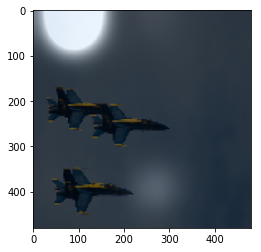

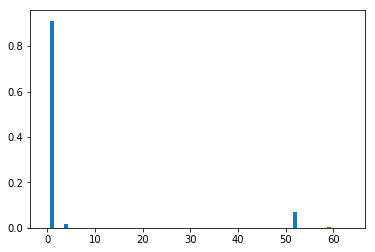

aeroplane 0.97978175
boat 0.01393424
bicycle 0.0031832082
motorbike 0.0008575042
cat 0.0007826507
sofa 0.0005503053
horse 0.00039285285
dog 0.0003189179
diningtable 0.00014659391
cow 5.2062413e-05
(480, 480, 3)


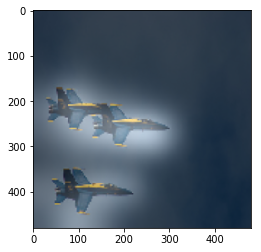

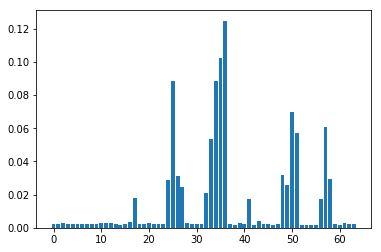

aeroplane 0.8241563
boat 0.15844612
bicycle 0.008787587
motorbike 0.00333906
sofa 0.0022421654
cat 0.0009505726
horse 0.00086007477
diningtable 0.0006134081
dog 0.00040761335
cow 0.00019710988
(480, 480, 3)


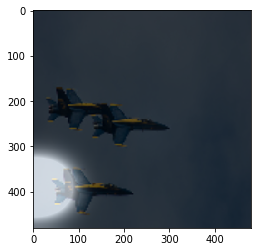

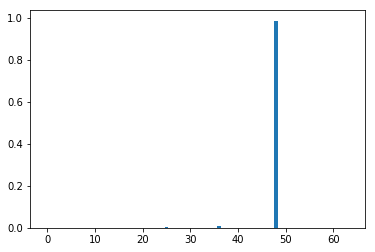

In [21]:
from scipy import signal
from scipy import ndimage

class_name = 'aeroplane'
class_id = name_to_class_dict[class_name]
class_mask = np.argmax(y_test, axis=1) == class_id
class_images = images_test[class_mask]
class_test_proba = test_proba_[class_mask]
class_proba_list = probabilities_list_[:,class_mask,:]
class_atts = atts_[:,class_mask,:]
print(class_proba_list.shape)
image_n = 5
rescale = IMG_SIZE / SMALLER_IMG_SIZE

for t in range(atts_.shape[0]):
    image = class_images[image_n]
    proba_res = class_proba_list[t,image_n,:]
#     print(proba_res)
#     print(class_to_name_dict[np.argmax(proba_res)])
    proba_res = [(i, proba) for i, proba in enumerate(proba_res)]
    proba_res.sort(key= lambda pair: pair[1], reverse=True)
#     print(proba_res)
    for i, proba in enumerate(proba_res):
        print(class_to_name_dict[proba[0]], proba[1])
    
    
    if rescale != 1:
        chosen_img = np.array(Utils.normalize(skimage.transform.rescale(image.copy(), rescale))) * 500
    else:
        chosen_img = image.copy()
    print(chosen_img.shape)
        
    chosen_attention = class_atts[t,image_n,:]
    
    result = np.zeros_like(chosen_img)
    for attended_patch_n in range(T):
        att_prob = chosen_attention[attended_patch_n]
#         print(att_prob)
#         print(attended_patch)
#         print(attended_patch_n/(IMG_SIZE/PATCH_WIDTH))
#         print(int(attended_patch%(IMG_SIZE/PATCH_WIDTH)))
        row = int(attended_patch_n/(IMG_SIZE/PATCH_WIDTH))
        col = int(attended_patch_n%(IMG_SIZE/PATCH_WIDTH))
#         print(attended_patch_n, row, col)
        from_y = row*PATCH_WIDTH
        to_y = from_y+PATCH_WIDTH

        from_x = col*PATCH_WIDTH
        to_x = from_x+PATCH_WIDTH
#         print(from_x, from_y)
        result[from_y:to_y, from_x:to_x, :] = np.ones_like(result[from_x:to_x,from_y:to_y,:]) * 255 * att_prob

    
    result = result / 255.
    chosen_img = chosen_img / 255.
    result = ndimage.gaussian_filter(result, sigma=32) * 8
    result[result > 1] = 1
    res = Utils.normalize(0.3 * chosen_img + result)
    plt.imshow(res)
    plt.show()
    
    plt.bar(range(atts_.shape[2]), chosen_attention)
    plt.show()

Normalized confusion matrix


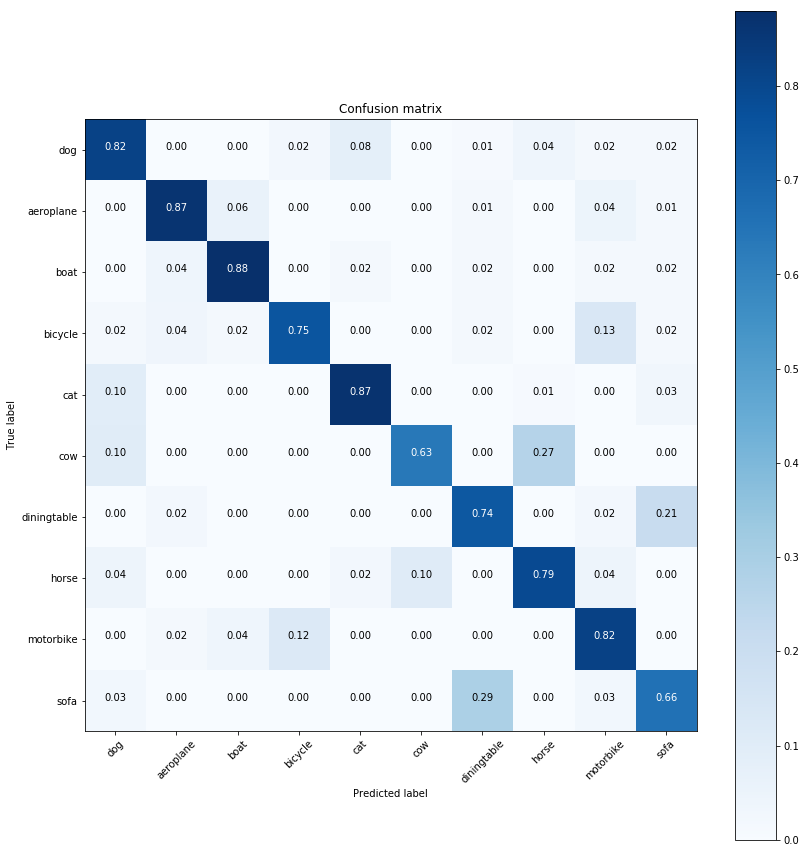

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt.gcf()

from sklearn.metrics import confusion_matrix

y_pred_proba = test_proba_

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape

cnf_matrix = confusion_matrix(y_test_argmax, y_pred)

import itertools

plt.figure(figsize=(12,12))
fig = plot_confusion_matrix(cnf_matrix, class_names, normalize=True)